# Main training notebook

## Imports

In [1]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet50, ResNet50_Weights

from torchvision.ops import FeaturePyramidNetwork

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

from nilearn import datasets
from nilearn import plotting

from tqdm import tqdm

import numpy as np

import os

import matplotlib.pyplot as plt

from scipy.stats import pearsonr as corr

from utils.dataset import Dataset
from utils.model import RegressionHead

## Hyperparameters

In [2]:
EPOCHS = 50
lr = 2e-3
batch_size = 32
l2 = 0.00002

## Load dataset

Loading dataset sample names...
Training images: 8779
Test images: 395

LH training fMRI data shape:
(8779, 19004)
(Training stimulus images × LH vertices)


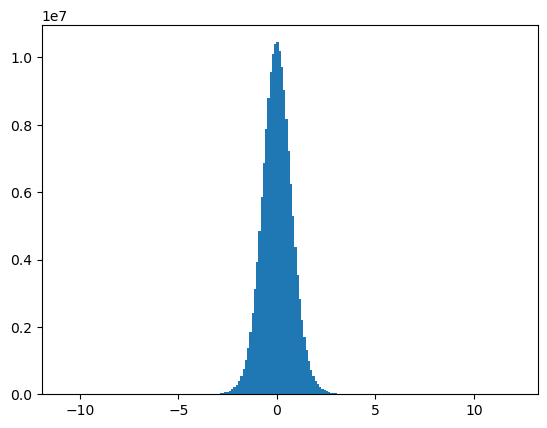

In [3]:
# loading dataset + creating train test split for verifying performance
dataset = Dataset("../../data/subj04")

train_set, val_set = torch.utils.data.random_split(dataset, [8200, 579])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

## Feature extractor + trainable regression head instantiation

In [4]:
# loading pretrained model
device = torch.device("cuda")

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

layer_names = []

for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer_names += [name]

print(layer_names)

feature_extractor = create_feature_extractor(model, 
        return_nodes=["layer1.2.conv3", "layer2.3.conv3", "layer3.5.conv3", "layer4.2.conv3"]).to(device)
fpn = FeaturePyramidNetwork([256, 512, 1024, 2048], 512).to(device)

feature_extractor.eval()

# instantiating trainable head
head = RegressionHead(19004).to(device)

['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.0.downsample.0', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3', 'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3', 'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3', 'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3', 'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3', 'layer4.0.downsample.0', 'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3', 'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3']


## Instantiating loss function + optimizer

In [5]:
# used to make spread more closely match target distribution
def squared_spread_loss():
    def loss(output, target):
        output_std = torch.std(output)
        target_std = torch.std(target)
        return (output_std - target_std) ** 2
    return loss

In [6]:
mse_weight = 0.5
spread_weight = 0.5

criterion = nn.MSELoss() # loss
auxiliary_spread_loss = squared_spread_loss() # auxiliary loss
optimizer = torch.optim.Adam(head.parameters(), lr=lr, weight_decay=l2) # optimizer

## Main training loop

In [8]:
train_loss = 0
mse_train_loss = 0
val_loss = 0
mse_val_loss = 0
count = 0

all_train_loss_vals = []
all_val_loss_vals = []

for epoch in range(EPOCHS):

    print("\nEpoch " + str(epoch))

    # setting to train mode for gradient calculations
    head.train()

    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=int(8500/batch_size)+1):
        inputs = inputs.to(device)
        # targets = targets.to(device)[:, np.where(challenge_roi)[0]] # selecting proper vertices based on ROI
        targets = targets.to(device)

        optimizer.zero_grad()

        # feature extractor backbone
        outputs = feature_extractor(inputs)
        outputs = fpn(outputs)

        # trainable head
        outputs = head(outputs)

        mse_loss = (mse_weight * criterion(outputs, targets))
        loss = mse_loss + (spread_weight * auxiliary_spread_loss(outputs, targets))
        loss.backward()

        del inputs
        del targets
        del outputs

        count += 1

        mse_train_loss = mse_train_loss + mse_loss.item()
        train_loss = train_loss + loss.item()

        optimizer.step()

        torch.cuda.empty_cache() # frees up memory for val

    all_train_loss_vals += [(mse_train_loss * 10 / 5)/count]
    
    print("Train loss: " + str(train_loss/count))
    print("Raw MSE train loss: " + str((mse_train_loss * 10 / 5)/count))

    count = 0

    head.eval()
    
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(val_loader), total=int(582/batch_size)+1):
            inputs = inputs.to(device)
            #targets = targets.to(device)[:, np.where(challenge_roi)[0]] # selecting proper vertices based on ROI
            targets = targets.to(device)
            
            # feature extractor backbone
            outputs = feature_extractor(inputs)
            outputs = fpn(outputs)

            # trainable head
            outputs = head(outputs)

            mse_loss = (mse_weight * criterion(outputs, targets))
            loss = mse_loss + (spread_weight * auxiliary_spread_loss(outputs, targets))

            del inputs
            del targets
            del outputs

            count += 1

            mse_val_loss = mse_val_loss + mse_loss.item()
            val_loss = val_loss + loss.item()

            torch.cuda.empty_cache() # frees up memory for val

    all_val_loss_vals += [(mse_val_loss * 10 / 5)/count]
    
    print("Val loss: " + str(val_loss/count))
    print("Raw MSE val loss: " + str((mse_val_loss * 10 / 5)/count))

    train_loss = 0
    mse_train_loss = 0
    val_loss = 0
    mse_val_loss = 0
    
    count = 0


Epoch 0


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.3381893133838817
Raw MSE train loss: 0.6042743206951868


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.34947213844249125
Raw MSE val loss: 0.6518349208329853

Epoch 1


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.3322075916171538
Raw MSE train loss: 0.5963180829346876


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.34851596386809097
Raw MSE val loss: 0.6371958914556002

Epoch 2


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.32825761558016914
Raw MSE train loss: 0.5915638632811461


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.3394327540146677
Raw MSE val loss: 0.5794815405418998

Epoch 3


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.3251553581382514
Raw MSE train loss: 0.5865039405655769


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.3316879248932788
Raw MSE val loss: 0.5926993442209143

Epoch 4


 97%|█████████▋| 257/266 [05:17<00:11,  1.23s/it]


Train loss: 0.32383981776144716
Raw MSE train loss: 0.5850719010551616


100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


Val loss: 0.35066832680451243
Raw MSE val loss: 0.6680557539588526

Epoch 5


 97%|█████████▋| 257/266 [05:17<00:11,  1.23s/it]


Train loss: 0.32287736474771905
Raw MSE train loss: 0.5838407358074931


100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


Val loss: 0.34458421562847336
Raw MSE val loss: 0.6320601889961645

Epoch 6


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.32301031656070445
Raw MSE train loss: 0.5842251781127796


100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Val loss: 0.34940446677960846
Raw MSE val loss: 0.6300992291224631

Epoch 7


 97%|█████████▋| 257/266 [05:10<00:10,  1.21s/it]


Train loss: 0.3210935436102203
Raw MSE train loss: 0.580779868804991


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Val loss: 0.3458153119212703
Raw MSE val loss: 0.6293898726764479

Epoch 8


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.32242435727138
Raw MSE train loss: 0.5832945836657216


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Val loss: 0.3431191413026107
Raw MSE val loss: 0.6423715807889637

Epoch 9


 97%|█████████▋| 257/266 [05:11<00:10,  1.21s/it]


Train loss: 0.3210806374651913
Raw MSE train loss: 0.5803075651946235


100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Val loss: 0.34398450506360906
Raw MSE val loss: 0.6262881410749335

Epoch 10


 97%|█████████▋| 257/266 [05:11<00:10,  1.21s/it]


Train loss: 0.3209442801280708
Raw MSE train loss: 0.5797764536007833


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.3493971165857817
Raw MSE val loss: 0.620043556941183

Epoch 11


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.3205540576217703
Raw MSE train loss: 0.57850229055965


100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Val loss: 0.34745473140164423
Raw MSE val loss: 0.6577516260899996

Epoch 12


 97%|█████████▋| 257/266 [05:11<00:10,  1.21s/it]


Train loss: 0.32127887126536686
Raw MSE train loss: 0.5790834939433442


100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Val loss: 0.3442507621489073
Raw MSE val loss: 0.6589964126285753

Epoch 13


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.31939081847667694
Raw MSE train loss: 0.5769777642381795


100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Val loss: 0.35831581526680994
Raw MSE val loss: 0.6937201289754165

Epoch 14


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.31968340382037924
Raw MSE train loss: 0.5771579873469089


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Val loss: 0.32067909287778956
Raw MSE val loss: 0.5860198798932528

Epoch 15


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.31827433668221944
Raw MSE train loss: 0.5746814728015128


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.33802871955068486
Raw MSE val loss: 0.6183097864452162

Epoch 16


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.3173907509341778
Raw MSE train loss: 0.5735224477279974


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.32903918310215596
Raw MSE val loss: 0.5846227250601116

Epoch 17


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.31732690467676766
Raw MSE train loss: 0.5735202320354922


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Val loss: 0.3375132209376285
Raw MSE val loss: 0.6167799265761125

Epoch 18


 97%|█████████▋| 257/266 [05:11<00:10,  1.21s/it]


Train loss: 0.3178985884217437
Raw MSE train loss: 0.5749761554981484


100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Val loss: 0.33616714101088674
Raw MSE val loss: 0.6110405169035259

Epoch 19


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.3161109155370104
Raw MSE train loss: 0.5721932015298405


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Val loss: 0.33252155780792236
Raw MSE val loss: 0.6042263178448928

Epoch 20


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.31625473105026125
Raw MSE train loss: 0.5719201372291327


100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Val loss: 0.3344700603108657
Raw MSE val loss: 0.6112341692573146

Epoch 21


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.31450988068190994
Raw MSE train loss: 0.5698225090012012


100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Val loss: 0.33417960373978867
Raw MSE val loss: 0.5943350791931152

Epoch 22


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.31479715060167274
Raw MSE train loss: 0.5699129410754846


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Val loss: 0.32385663923464325
Raw MSE val loss: 0.5905311923278006

Epoch 23


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.3125212261532995
Raw MSE train loss: 0.5663410299946826


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Val loss: 0.34094369568322835
Raw MSE val loss: 0.6456805718572516

Epoch 24


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.3130361746837193
Raw MSE train loss: 0.5672727667867905


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Val loss: 0.32443498859280034
Raw MSE val loss: 0.5794583229642165

Epoch 25


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.31221273321122045
Raw MSE train loss: 0.5663146737252692


100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


Val loss: 0.3500977629109433
Raw MSE val loss: 0.6624733523318642

Epoch 26


 97%|█████████▋| 257/266 [05:16<00:11,  1.23s/it]


Train loss: 0.3098557100337767
Raw MSE train loss: 0.5619689720150097


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.32179027325228643
Raw MSE val loss: 0.5840688347816467

Epoch 27


 97%|█████████▋| 257/266 [05:17<00:11,  1.23s/it]


Train loss: 0.3092181051751519
Raw MSE train loss: 0.5615534146936023


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Val loss: 0.31805887818336487
Raw MSE val loss: 0.568032947025801

Epoch 28


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.3081915449307586
Raw MSE train loss: 0.5593747493126049


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.32123456816924245
Raw MSE val loss: 0.5981596018138685

Epoch 29


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.3078082268224152
Raw MSE train loss: 0.5587074776335913


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.3231096455925389
Raw MSE val loss: 0.5953602665349057

Epoch 30


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.3049890888340278
Raw MSE train loss: 0.5539505678855955


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.3219921683010302
Raw MSE val loss: 0.5808472194169697

Epoch 31


 97%|█████████▋| 257/266 [05:17<00:11,  1.23s/it]


Train loss: 0.30420743607361495
Raw MSE train loss: 0.552380376984637


100%|██████████| 19/19 [00:10<00:00,  1.90it/s]


Val loss: 0.3188823837982981
Raw MSE val loss: 0.5880561282760218

Epoch 32


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.30453072354951255
Raw MSE train loss: 0.5531149655000709


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.3184094303532651
Raw MSE val loss: 0.5854472219944

Epoch 33


 97%|█████████▋| 257/266 [05:17<00:11,  1.24s/it]


Train loss: 0.30325937537831554
Raw MSE train loss: 0.5507508736640099


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.32635424168486343
Raw MSE val loss: 0.611784406398472

Epoch 34


 97%|█████████▋| 257/266 [05:20<00:11,  1.25s/it]


Train loss: 0.30146025144404476
Raw MSE train loss: 0.5480273786917734


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.3424740998368514
Raw MSE val loss: 0.6518625679769015

Epoch 35


 97%|█████████▋| 257/266 [05:16<00:11,  1.23s/it]


Train loss: 0.3018356283930953
Raw MSE train loss: 0.5486851211651754


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.3313810190087871
Raw MSE val loss: 0.6204328066424319

Epoch 36


 97%|█████████▋| 257/266 [05:15<00:11,  1.23s/it]


Train loss: 0.30139884387472726
Raw MSE train loss: 0.5476737705418108


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.33314229940113266
Raw MSE val loss: 0.6162613944003457

Epoch 37


 97%|█████████▋| 257/266 [05:16<00:11,  1.23s/it]


Train loss: 0.2984326314253566
Raw MSE train loss: 0.5425220403225969


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.3241281038836429
Raw MSE val loss: 0.6005871688064776

Epoch 38


 97%|█████████▋| 257/266 [05:14<00:10,  1.22s/it]


Train loss: 0.29775482334979314
Raw MSE train loss: 0.5416256222975393


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


Val loss: 0.320632079714223
Raw MSE val loss: 0.5894944307051206

Epoch 39


 97%|█████████▋| 257/266 [05:13<00:10,  1.22s/it]


Train loss: 0.29809268062448685
Raw MSE train loss: 0.5426686631102506


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.3332606114839253
Raw MSE val loss: 0.6152956987682142

Epoch 40


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.2970207868151164
Raw MSE train loss: 0.5406755868794854


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Val loss: 0.3236091419270164
Raw MSE val loss: 0.587144219561627

Epoch 41


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.29520961416138747
Raw MSE train loss: 0.5373236563651015


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Val loss: 0.3213108550561102
Raw MSE val loss: 0.5966308775701021

Epoch 42


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.2939296124742189
Raw MSE train loss: 0.5357659812799224


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.32601050718834523
Raw MSE val loss: 0.6030071362068778

Epoch 43


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.29337343324251214
Raw MSE train loss: 0.5343431380472294


100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


Val loss: 0.33029356598854065
Raw MSE val loss: 0.6063523527822996

Epoch 44


 97%|█████████▋| 257/266 [05:11<00:10,  1.21s/it]


Train loss: 0.29237808982917773
Raw MSE train loss: 0.5331079819554949


100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Val loss: 0.33017060788054214
Raw MSE val loss: 0.6097148625474227

Epoch 45


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.2902916634477066
Raw MSE train loss: 0.5294757697600799


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Val loss: 0.3338160624629573
Raw MSE val loss: 0.6130682669187847

Epoch 46


 97%|█████████▋| 257/266 [05:12<00:10,  1.21s/it]


Train loss: 0.2900076351393058
Raw MSE train loss: 0.5290735239880558


100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Val loss: 0.32752656858218343
Raw MSE val loss: 0.6164621475495791

Epoch 47


 97%|█████████▋| 257/266 [05:11<00:10,  1.21s/it]


Train loss: 0.28925708603070405
Raw MSE train loss: 0.5281071091208477


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.34144322652565806
Raw MSE val loss: 0.6422601373572099

Epoch 48


 97%|█████████▋| 257/266 [05:12<00:10,  1.22s/it]


Train loss: 0.28756173859542444
Raw MSE train loss: 0.5252863726495305


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Val loss: 0.32863644549721166
Raw MSE val loss: 0.6016540119522497

Epoch 49


 97%|█████████▋| 257/266 [05:15<00:11,  1.23s/it]


Train loss: 0.28589688890870907
Raw MSE train loss: 0.5227785475755016


100%|██████████| 19/19 [00:09<00:00,  1.91it/s]

Val loss: 0.32946675466863734
Raw MSE val loss: 0.6075134183231153


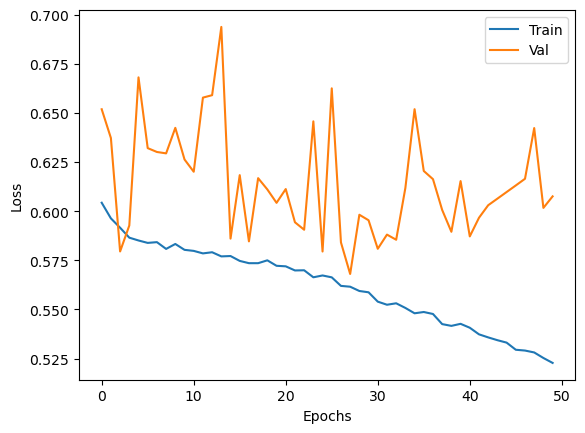

In [9]:
plt.plot([i for i in range(EPOCHS)], all_train_loss_vals, label="Train")
plt.plot([i for i in range(EPOCHS)], all_val_loss_vals, label="Val")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./loss_graphs/50_epochs_subj4_left3.png")

## Saving trained model

In [10]:
torch.save(head.state_dict(), "saved_models/50_epochs_subj4_left_4")

## Output distribution visualization

Output dims: torch.Size([19004])
Target dims: torch.Size([19004])
Output mean: tensor(-0.0631, device='cuda:0')
Target mean: tensor(-0.5508)
Output standard deviation: tensor(0.4415, device='cuda:0')
Target standard deviation: tensor(0.9620)
Loss: tensor(0.9710)


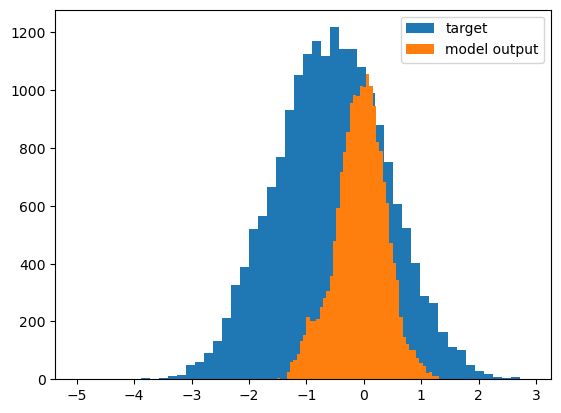

In [16]:
sample = next(iter(train_loader))

feature_extractor.to(device)
fpn.to(device)
head.to(device)

visualize_output = feature_extractor(sample[0].to(device))
visualize_output = fpn(visualize_output)
visualize_output = head(visualize_output).detach()

print("Output dims: " + str(visualize_output[0].size()))
print("Target dims: " + str(sample[1][0].size()))

print("Output mean: " + str(torch.mean(visualize_output[0])))
print("Target mean: " + str(torch.mean(sample[1][0])))

print("Output standard deviation: " + str(torch.std(visualize_output[0])))
print("Target standard deviation: " + str(torch.std(sample[1][0])))

loss = criterion(visualize_output[0].to("cpu"), sample[1][0].to("cpu"))

print("Loss: " + str(loss))

plt.hist(sample[1][0].numpy(), bins=50, label="target")
plt.hist(visualize_output[0].to("cpu").numpy(), bins=50, label="model output")
plt.legend(loc="upper right")
plt.savefig("histograms/" + "50_epoch" + ".jpg")

## Submission correlation score test

In [18]:
feature_extractor.to(device)
fpn.to(device)
head.to(device)

feature_extractor.eval()
head.eval()

n_left_vertices = 19004

left_outputs = torch.zeros(841, n_left_vertices).to(device)

final_left_targets = torch.zeros(841, n_left_vertices).to(device)

with torch.no_grad():
    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=int(300/batch_size)+1):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = feature_extractor(inputs)
        outputs = fpn(outputs)
        # trainable head
        outputs = head(outputs)

        final_left_targets[i*batch_size:i*batch_size+batch_size] = targets
        left_outputs[i*batch_size:i*batch_size+batch_size] = outputs
        
        del inputs
        del targets
        del outputs

        torch.cuda.empty_cache() # frees up memory

        if i == 8:
            break

lh_correlation = torch.zeros(final_left_targets.shape[1])
for v in tqdm(range(final_left_targets.shape[1])):
    lh_correlation[v] = torch.tensor(corr(left_outputs[:,v].detach().cpu(), final_left_targets[:,v].detach().cpu())[0]) ** 2

score = torch.median(lh_correlation) * 100

print(score)

100%|██████████| 19004/19004 [00:05<00:00, 3350.71it/s]

tensor(18.6716)
